#### 1 Author ####
Student Name:Rui Chen
Student ID:210978863

#### 2 Problem formulation ####

Based on Genki4k dataset which is a dataset from "http://mplab.ucsd.edu" and the title as "the MPLab GENKI Database, GENKI-4K Subset", we need to finish two tasks, smile detection and 3D head pose estimation.Our goal is trainning a model to correctly predict if the person is smilling and his head pose after we input a image.
Every image was labeled as "1" or "0" which means "smile" or "unsmile", there are also three other labels for head pose prediction.Because we already have the labels for all items in the datasets,so we choose classification which is supervised learning.

#### 3 Machine Learning pipeline ####

There are four main step to do the task:data preprocess,split data,train the model,test(evaluate) the model

In this task,we use two models to do smile-detection and head pose estimation.
The first one is classification for smile-detection, after input, the output is the state and probability.
The second one is regression, using a regression model to predict the yaw,pitch and roll of a image, 

#### 4 Transformation Stage ####

In the transfomation stage, we need to transform the data so that it can be used to fit a model. For example, we do some preproces, data augmentation etc.I use 68_face_landmarks to extract useful face information. During the process of extracting faces, simple geometric transformations are applied by cropping the facial region and resizing it and this process can be seen as a mild data augmentation.

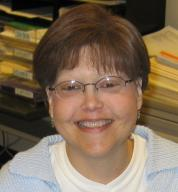

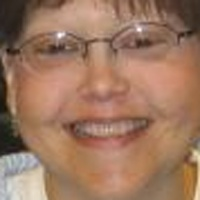

In [65]:
from IPython.display import Image, display

# File paths for images
image_path1 = 'genki4k/files/file0001.jpg'
image_path2 = 'genki4k/files(preprocess)/file1.jpg'

# Display the two images
display(Image(filename=image_path1))
display(Image(filename=image_path2))

#### 5 Modelling ####

This code defines a PyTorch module for constructing ResNet models and this provides flexible tools for constructing ResNet models so that different ResNet variants like `resnet34`, `resnet50`, `resnet101`, `resnext50_32x4d`, `resnext101_32x8d` can be easily chosen. 
1.BasicBlock class:
This class defines the basic residual block of ResNet, consisting of two convolutional layers and an identity mappinc2.k.
Bottleneck cls:

This class defines the bottleneck residual block of ResNet, consisting of three convolutional layers and an identity ma 3.block.
ResNelass:

This class is the main definition for the entire Reset model.
The __init__ method initializes various layers of the ResNet model, including convolutional layers, batch normalization lyers, etc.
The _make_layer method constructs the layers of ResNet, including multiple resiual blocks.
The forward method implements the entire forward pass of the i4.er is optional.
WeighInitialization:

At the end of the __init__ method, the nn.init.kaiming_normal_ method is used to initialize the weights of all convolutional layers using th Kaiming ini
tializ mHere are some reason that I chose resnet:chFirstly, addressing the vanishing gradient problem. ient proble** In deep neural networks, the vanishing gradient problem makes training deep networks challenging. ResNet mitigates this issue by allowing information to be directly passed between layers through residual making it easier to train deep networks.  making it easSecondly,it can also support for deeper tworks and i
Improved generalizacetion performan.

As for resnet34,it has lower model complexity, resulting in fewer model parameters and lower computational costs. This makes it easier to train and deploy, especially in resource-constrained scenarios.Secondly it is s
Suitable for medium-sized datase like our datasets and get excellent performance.sks.e.aints.ng in practical tasks.

It is loading weight. This process is called after creating the model, and its purpose is to initialize the model's parameters with the weights learned from a pre-trained model. This way, the model inherits the feature representations learned by the pre-trained model and can be fine-tuned or further trained for specific tasks.

In [ ]:
import os
import torch
import torch.nn as nn
from resnet import resnet34


def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # load pretrain weights
    # download url: https://download.pytorch.org/models/resnet34-333f7ec4.pth
    model_weight_path = "./resnet34-pre.pth"
    assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)

    net = resnet34()
    net.load_state_dict(torch.load(model_weight_path, map_location=device))
    # change fc layer structure
    in_channel = net.fc.in_features
    net.fc = nn.Linear(in_channel, 5)

if __name__ == '__main__':
    main()

In [ ]:
import torch.nn as nn
import torch

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    """
    Note: In the original paper, on the main branch of the dashed residual structure, the first 1x1 convolutional layer has a step of 2 and the second 3x3 convolutional layer has a step of 1.
    However, in the official pytorch implementation, the first 1x1 convolutional layer has a step of 1, and the second 3x3 convolutional layer has a step of 2.
    The advantage of doing this is that it can improve the accuracy of top1 by about 0.5%.
    See also Resnet v1.5 https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch
    """
    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None,
                 groups=1, width_per_group=64):
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=width,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, groups=groups,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=width, out_channels=out_channel*self.expansion,
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 blocks_num,
                 num_classes=1000,
                 include_top=True,
                 groups=1,
                 width_per_group=64):
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.groups = groups
        self.width_per_group = width_per_group

        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel,
                            channel,
                            downsample=downsample,
                            stride=stride,
                            groups=self.groups,
                            width_per_group=self.width_per_group))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel,
                                channel,
                                groups=self.groups,
                                width_per_group=self.width_per_group))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x

def resnet34(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet34-333f7ec4.pth
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet50(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet50-19c8e357.pth
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet101(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)


def resnext50_32x4d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth
    groups = 32
    width_per_group = 4
    return ResNet(Bottleneck, [3, 4, 6, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


def resnext101_32x8d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth
    groups = 32
    width_per_group = 8
    return ResNet(Bottleneck, [3, 4, 23, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)

#### 6 Methodology ####

Step 1 preprocess (The process is detailed in Part 7)

The first step of this task is data preprocessing.In this task, no matter smile detection or head pose estimation we just need pixels that contain information of face.Here we import some useful packages to help us extract face and data processing.

Step 2 split the dataset

Before training, we should split the dataset.In this task,firstly we split the images into two folders,"smile" and "unsmile" through the given labels.Basic machine learning methodologies include two seperate tasks:training and testing, in the training stage,we fit a model to a dataset.We split the dataset for training and find the underlying pattern.
In this project,we want to find a model to predict something,to get a better performance,after we get a model,we will use it and validate the accuracy of this model. So we need to split a dataset into three parts:train,test and validation,the ratio is (0.6,0.2,0.2).The code below shows how I split the dataset.
Splitting data can also preventing overfitting, because it make sure that the model doesn't only fit one dataset but other data.

We input the whole genki4k dataset and get 5 folders,"smile","unsmile","train","test","val".The "smile","unsmile" folder is used to classify the items and the other three folders are used to store images for train, test and validation.

In [33]:
def split_into_two(i=None):
    # set the output path
    data_folder = "genki4k/files(preprocess)"

    # create two folders to split the data
    os.makedirs("genki4k/files(splitdata)/smile", exist_ok=True)
    os.makedirs("genki4k/files(splitdata)/unsmile", exist_ok=True)

    #get all the files
    files = os.listdir(data_folder)

    # files.sort(key=lambda x: int(x.replace("file", "").split('.')[0]))
    fnames = ['file{}.jpg'.format(i) for i in range(1,2164)]
    for fname in fnames:
        src = os.path.join("genki4k/files(preprocess)", fname)
        dst = os.path.join("genki4k/files(splitdata)/smile", fname)
        shutil.copyfile(src, dst)

    fnames = ['file{}.jpg'.format(i) for i in range(2164,3879)]
    for fname in fnames:
        src = os.path.join("genki4k/files(preprocess)", fname)
        dst = os.path.join("genki4k/files(splitdata)/unsmile", fname)
        shutil.copyfile(src, dst)

    print("split into smile or unsmile done!")

def split_into_three():
    # the ratio of [train,test,val] is [0.6,0.2,0.2]
    split_ratio = [0.6, 0.2, 0.2]

    # create output folders
    output_folder = ["genki4k/files(splitdata)/train", "genki4k/files(splitdata)/test", "genki4k/files(splitdata)/val"]
    for folder in output_folder:
        os.makedirs(os.path.join(folder, "smile"), exist_ok=True)
        os.makedirs(os.path.join(folder, "unsmile"), exist_ok=True)

    # split smile folders into three folders, we use 'random' to assign images
    smile_files = os.listdir("genki4k/files(splitdata)/smile")
    random.shuffle(smile_files)
    total_smile_files = len(smile_files)
    split_index_smile = [int(total_smile_files * split_ratio[0]), int(total_smile_files * (split_ratio[0] + split_ratio[1]))]

    for i, file in enumerate(smile_files):
        if i < split_index_smile[0]:
            shutil.copy(os.path.join("genki4k/files(splitdata)/smile", file), os.path.join("genki4k/files(splitdata)/train", "smile", file))
        elif i < split_index_smile[1]:
            shutil.copy(os.path.join("genki4k/files(splitdata)/smile", file), os.path.join("genki4k/files(splitdata)/test", "smile", file))
        else:
            shutil.copy(os.path.join("genki4k/files(splitdata)/smile", file), os.path.join("genki4k/files(splitdata)/val", "smile", file))

    # same as before
    unsmile_files = os.listdir("genki4k/files(splitdata)/unsmile")
    random.shuffle(unsmile_files)
    total_unsmile_files = len(unsmile_files)
    split_index_unsmile = [int(total_unsmile_files * split_ratio[0]), int(total_unsmile_files * (split_ratio[0] + split_ratio[1]))]

    for i, file in enumerate(unsmile_files):
        if i < split_index_unsmile[0]:
            shutil.copy(os.path.join("genki4k/files(splitdata)/unsmile", file), os.path.join("genki4k/files(splitdata)/train", "unsmile", file))
        elif i < split_index_unsmile[1]:
            shutil.copy(os.path.join("genki4k/files(splitdata)/unsmile", file), os.path.join("genki4k/files(splitdata)/test", "unsmile", file))
        else:
            shutil.copy(os.path.join("genki4k/files(splitdata)/unsmile", file), os.path.join("genki4k/files(splitdata)/val", "unsmile", file))

    print("split into train,test or val done!")

if __name__ == "__main__":
    split_into_two()
    split_into_three()

split into smile or unsmile done!
split into train,test or val done!


Step 3 Train the model

In [37]:
import sys
import json

def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        "val": transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

    data_root = os.path.abspath(os.path.join(os.getcwd(), "../Miniproject"))  # get data root path
    image_path = os.path.join(data_root, "genki4k", "files(splitdata)")  # genki4k data set path
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)

    flower_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in flower_list.items())
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    batch_size = 16 #the number of samples to be used in each iteration
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)

    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                                            transform=data_transform["val"])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)

    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))
    
    net = resnet34()
    # load pretrain weights
    # download url: https://download.pytorch.org/models/resnet34-333f7ec4.pth
    model_weight_path = "./resnet34-pre.pth"
    assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
    net.load_state_dict(torch.load(model_weight_path, map_location='cpu'))
    # for param in net.parameters():
    #     param.requires_grad = False

    # change fc layer structure
    in_channel = net.fc.in_features
    net.fc = nn.Linear(in_channel, 5)
    net.to(device)

    # define loss function
    loss_function = nn.CrossEntropyLoss()

    # construct an optimizer
    params = [p for p in net.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr=0.0001)

    epochs = 3
    best_acc = 0.0
    save_path = './resNet34.pth'
    train_steps = len(train_loader)
    for epoch in range(epochs):
        # train
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, file=sys.stdout)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            logits = net(images.to(device))
            loss = loss_function(logits, labels.to(device))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)

        # validate
        net.eval()
        acc = 0.0  # accumulate accurate number / epoch
        with torch.no_grad():
            val_bar = tqdm(validate_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                # loss = loss_function(outputs, test_labels)
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

                val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1,
                                                           epochs)

        val_accurate = acc / val_num
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / train_steps, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')


if __name__ == '__main__':
    main()

using cpu device.
Using 8 dataloader workers every process
using 2303 images for training, 768 images for validation.
valid epoch[1/3]: 100%|████████████████████████████████████████████████████████████████| 48/48 [00:44<00:00,  1.07it/s]
[epoch 1] train_loss: 0.556  val_accuracy: 0.871
valid epoch[2/3]: 100%|████████████████████████████████████████████████████████████████| 48/48 [00:44<00:00,  1.07it/s]
[epoch 2] train_loss: 0.380  val_accuracy: 0.931
valid epoch[3/3]: 100%|████████████████████████████████████████████████████████████████| 48/48 [00:44<00:00,  1.09it/s]
[epoch 3] train_loss: 0.326  val_accuracy: 0.924
Finished Training


This is for head pose estimation

In [30]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split


# Define the dataset class
class GenkiDataset(Dataset):
    def __init__(self, labels_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(labels_file, delim_whitespace=True, header=None)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = f"{self.img_dir}/file{idx + 1:04d}.jpg"
        image = Image.open(img_name).convert("RGB")
        label = self.img_labels.iloc[idx, 1:4].values.astype(float)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)


# Define the ResNet-based model
class HeadPoseNet(nn.Module):
    def __init__(self):
        super(HeadPoseNet, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 3)  # Output size is 3 for pitch, yaw, and roll

    def forward(self, x):
        return self.resnet(x)


# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and dataloaders
labels_file = 'genki4k/labels.txt'
img_dir = 'genki4k/files'
genki_dataset = GenkiDataset(labels_file=labels_file, img_dir=img_dir, transform=transform)

# Split the dataset into training and validation sets
train_idx, valid_idx = train_test_split(range(len(genki_dataset)), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(genki_dataset, train_idx)
valid_dataset = torch.utils.data.Subset(genki_dataset, valid_idx)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
model = HeadPoseNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for images, labels in valid_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

        average_loss = total_loss / len(valid_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {average_loss:.4f}')

# Save the trained model
torch.save(model.state_dict(), 'headpose_resnet34_model.pth')


Epoch [1/10], Validation Loss: 0.0185
Epoch [2/10], Validation Loss: 0.0105
Epoch [3/10], Validation Loss: 0.0206
Epoch [4/10], Validation Loss: 0.0112
Epoch [5/10], Validation Loss: 0.0122
Epoch [6/10], Validation Loss: 0.0161
Epoch [7/10], Validation Loss: 0.0327
Epoch [8/10], Validation Loss: 0.0143
Epoch [9/10], Validation Loss: 0.0109
Epoch [10/10], Validation Loss: 0.0083


Step4 Testing 
In this part,we will test the model on the 'test' dataset to evaluate its performance.(The detailed process is in part 8)

7 Dataset

The Genki4k dataset has 4000 images,containing expressions and head-pose labels,we split the dataset into "train","test" and "val" to build a model.Before training, we need to preprocess the dataset, extract useful information from the images.

'shape_predictor_68_face_landmarks.data'is a set of 68 specific points on the face. Each landmark corresponds to a specific location on the face, such as the corners of the eyes, nose, mouth, and other facial contours.We use this set to extract the face in the image which is also used to discard some irrelevant noise in the data.

In [14]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [15]:
path_read = "genki4k/files"
num=0
for file_name in os.listdir(path_read):
    all_path = (path_read + "/" + file_name)
    img = cv2.imdecode(np.fromfile(all_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    # get width and height
    img_shape=img.shape
    img_height=img_shape[0]
    img_width=img_shape[1]
   
    os.makedirs("genki4k/files(preprocess)", exist_ok=True)#store each single face
    path_save = "genki4k/files(preprocess)"
    # dlib detection
    dets = detector(img , 1)
    for k, d in enumerate(dets):
        if len(dets) > 1:
            continue
        num=num+1
        
        # record the position
        pos_start = tuple([d.left(), d.top()])
        pos_end = tuple([d.right(), d.bottom()])
 
        # calculate the size
        height = d.bottom()-d.top()
        width = d.right()-d.left()
 
        # generate a blank image and copy the pixel
        img_blank = np.zeros((height, width, 3), np.uint8)
        for i in range(height):
            if d.top()+i >= img_height: # 防止越界
                continue
            for j in range(width):
                if d.left()+j >= img_width: # 防止越界
                    continue
                img_blank[i][j] = img[d.top()+i][d.left()+j]
        img_blank = cv2.resize(img_blank, (200, 200), interpolation=cv2.INTER_CUBIC)
 
        cv2.imencode('.jpg', img_blank)[1].tofile(path_save+"/"+"file"+str(num)+".jpg") # 正确方法
 
print("processing done!")


processing done!


#### 8 Result ####

This is for smile-detection model.

In [38]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms

from model import resnet34


def main(imgs_root):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # load image
    # 指向需要遍历预测的图像文件夹
    # imgs_root = "genki4k/files(splitdata)/test/unsmile"
    # imgs_root = "genki4k/files(splitdata)/test/smile"
    assert os.path.exists(imgs_root), f"file: '{imgs_root}' dose not exist."
    # 读取指定文件夹下所有jpg图像路径
    img_path_list = [os.path.join(imgs_root, i) for i in os.listdir(imgs_root) if i.endswith(".jpg")]

    # read class_indict
    json_path = './class_indices.json'
    assert os.path.exists(json_path), f"file: '{json_path}' dose not exist."

    json_file = open(json_path, "r")
    class_indict = json.load(json_file)

    # create model
    model = resnet34(num_classes=5).to(device)

    # load model weights
    weights_path = "./resNet34.pth"
    assert os.path.exists(weights_path), f"file: '{weights_path}' dose not exist."
    model.load_state_dict(torch.load(weights_path, map_location=device))

    # prediction
    model.eval()
    batch_size = 8  # 每次预测时将多少张图片打包成一个batch
    with torch.no_grad():
        for ids in range(0, len(img_path_list) // batch_size):
            img_list = []
            for img_path in img_path_list[ids * batch_size: (ids + 1) * batch_size]:
                assert os.path.exists(img_path), f"file: '{img_path}' dose not exist."
                img = Image.open(img_path)
                img = data_transform(img)
                img_list.append(img)

            # batch img
            # 将img_list列表中的所有图像打包成一个batch
            batch_img = torch.stack(img_list, dim=0)
            # predict class
            output = model(batch_img.to(device)).cpu()
            predict = torch.softmax(output, dim=1)
            probs, classes = torch.max(predict, dim=1)
            for idx, (pro, cla) in enumerate(zip(probs, classes)):
                print("image: {}  class: {}  prob: {:.3}".format(img_path_list[ids * batch_size + idx],
                                                                 class_indict[str(cla.numpy())],
                                                                 pro.numpy()))


if __name__ == '__main__':
    main("genki4k/files(splitdata)/test/unsmile")
    main("genki4k/files(splitdata)/test/smile")

image: genki4k/files(splitdata)/test/unsmile\file2168.jpg  class: unsmile  prob: 0.973
image: genki4k/files(splitdata)/test/unsmile\file2176.jpg  class: unsmile  prob: 0.957
image: genki4k/files(splitdata)/test/unsmile\file2177.jpg  class: unsmile  prob: 0.977
image: genki4k/files(splitdata)/test/unsmile\file2187.jpg  class: unsmile  prob: 0.993
image: genki4k/files(splitdata)/test/unsmile\file2192.jpg  class: unsmile  prob: 0.931
image: genki4k/files(splitdata)/test/unsmile\file2198.jpg  class: unsmile  prob: 0.974
image: genki4k/files(splitdata)/test/unsmile\file2207.jpg  class: unsmile  prob: 0.992
image: genki4k/files(splitdata)/test/unsmile\file2208.jpg  class: unsmile  prob: 0.996
image: genki4k/files(splitdata)/test/unsmile\file2216.jpg  class: unsmile  prob: 0.995
image: genki4k/files(splitdata)/test/unsmile\file2217.jpg  class: unsmile  prob: 0.979
image: genki4k/files(splitdata)/test/unsmile\file2221.jpg  class: unsmile  prob: 0.97
image: genki4k/files(splitdata)/test/unsmile

In summary, in binary classification, a decision threshold is used to determine the class assignment based on the model's predicted probabilities, which is prosterior probability, it will belongs to the class that has higher probability. Actually we don't know the true prosterior probablity, which can only derived by Bayesian classification.
In smile-detection, at last we can evaluate the model on the test dataset. After calculation, we can get the test misclassification rate = (32+25 /(425+343)*100%=7.42%, so we have the test accuracy=92.58%.
I reviewed the picture of the error in judgement and concluded that there were several possible reasons for the error:
1.It is difficult to judge whether a smile and its emotions are present in the picture itself, and it is possible to misjudge it even by direct human observation.
2.Some actions interfere with categorisation, e.g. opening the mouth and showing the teeth is similar to smiling with the teeth open.
3.It is still affected by light and shadow, etc, noise immunity of the model needs to be improved.

In [47]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

from headpose2 import HeadPoseNet


# Define the dataset class (similar to the training dataset class)
class TestGenkiDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.num_samples = 1000  # Set the number of test samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        img_name = f"{self.img_dir}/file{idx + 1:04d}.jpg"
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

# Load the trained model
model = HeadPoseNet()
model.load_state_dict(torch.load('headpose_resnet34_model.pth'))
model.eval()

# Define transformations for test images
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the test dataset and dataloader
test_img_dir = 'genki4k/files'  # Provide the path to the directory containing test images
test_dataset = TestGenkiDataset(img_dir=test_img_dir, transform=test_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Test the model
model_predictions = []
with torch.no_grad():
    for images in test_loader:
        outputs = model(images)
        model_predictions.append(outputs.numpy())

# Concatenate the predictions from different batches
model_predictions = np.concatenate(model_predictions, axis=0)

# Display or further process the predictions as needed
print("Model Predictions:")
print(model_predictions)



Model Predictions:
[[-0.01750545  0.04791921 -0.03983924]
 [-0.10934243  0.07142161 -0.10967906]
 [ 0.03334953  0.00484018  0.06744011]
 ...
 [ 0.2679275   0.00716439 -0.02689921]
 [-0.12705871  0.01254077  0.07153283]
 [-0.10002096 -0.00118944 -0.07318167]]


And we can use these code to calculate loss

In [ ]:
# Define the loss function
criterion = nn.MSELoss()

# Test the model
total_loss = 0.0
num_batches = 0

with torch.no_grad():
    for images in test_loader:
        outputs = model(images)
        # Assuming true_labels is a tensor containing the true labels for the batch
        loss = criterion(outputs, true_labels[num_batches * test_loader.batch_size: (num_batches + 1) * test_loader.batch_size])
        total_loss += loss.item()
        num_batches += 1

# Calculate the average loss
average_loss = total_loss / num_batches

As for head pose estimation
We use loss to assess the performance of the model. In regression models, loss usually refers to the MSE, or Mean Square Error, which is usually as small as possible, sometimes with some adjustments depending on the robustness generalisability of the model.
In this experiment, we can see that the validation loss always around 0.01, which shows an excellent performance.

#### 9 Conlusions ####

1.To do a machine learning project, at first we should figure out the problem and choose a suitable method, supervised or unsupervised, classification or regression, density estimation or structure analysis.
2.Do some preprocess, all kinds of data augmentation and normalization to make the data more suitable for training.
3.Choose a suitable, it depend on the specific need, different weight of data and different input and output use different models,sometimes we need to mix them.
4.Train your model and evaluate it through some standard,MSE,Cross-Entropy loss and so on.Remember test it on the test dataset preventing overfitting.
5.Analyze the result and try to improve, no matter in datasets or methodology.